In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [130]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


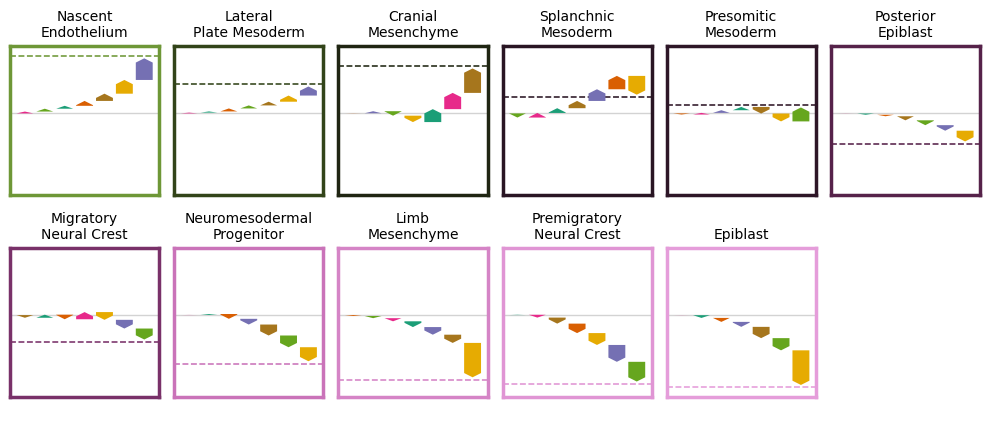

In [243]:
# average score, module attributions (per celltype)
msk = (adata.obs.celltype != 'nan') & \
    (adata.obs.trajectory == 'True') & \
    (adata.obs.source != 'GSE201257')
grp = adata[msk].obs.groupby(['source', 'celltype'], observed = True)
keep = grp.size() > 200
z = grp.latent_z.median().sort_values(ascending = False).loc[keep]
attr = grp[list(feat_dict.keys())].mean().loc[z.index]

# waterfall plots
wbar, dy_head, xpad, ypad, cmap_bar = .85, .035, .75, .1, plt.cm.Dark2
cdict = {col : cmap_bar(i) for i, col in enumerate(attr.columns)}
xlim = (-xpad, attr.shape[1] - 1 + xpad)
ymin = attr.sum(axis = 1).min() - ypad
ymax = attr.sum(axis = 1).max() + ypad

# plotting (grid)
ncol, nrow, grid_size, cmap_sp = 6, 2, 1.5, plt.cm.vanimo
fig, ax = plt.subplots(nrow, ncol, sharex = True, sharey = True, figsize = (10, 4.4))
for i, ix in enumerate(z.index):
    ax_i = ax[i // ncol, i % ncol]
    attr_i = attr.loc[ix].sort_values(key = abs)
    heads = attr_i.cumsum().to_numpy()
    tails = np.concat(([0], heads[:-1]))
    colors = attr_i.index.map(cdict)
  
    for j in range(heads.size):
        dy = heads[j] - tails[j]
        if dy > 0: hlen = min(dy, dy_head)
        else: hlen = -max(dy, -dy_head)
        arrow = FancyArrow(
            x = j,
            y = tails[j],
            dx = 0,
            dy = dy,
            width = wbar,
            head_width = wbar,
            head_length = hlen,
            length_includes_head = True,
            linewidth = 0,
            color = colors[j])
        ax_i.add_artist(arrow)

    ax_i.axhline(0,
                 color = 'lightgray',
                 linewidth = 1,
                 zorder = 0)
    
    ypad_line = .02 * np.sign(dy)
    ax_i.axhline(heads[-1] + ypad_line,
                 color = cmap_sp(z.loc[ix]),
                #  alpha = .75,
                 linestyle = '--',
                 linewidth = 1.15,
                 zorder = 0)

    ax_i.set_xlim(xlim)
    ax_i.set_ylim(ymin, ymax)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

    title = ix[1].replace(' ', '\n', 1)
    ax_i.set_title(title, size = 10, pad = 7)
    ax_i.set_box_aspect(1)

    for sp in ax_i.spines.values():
        sp.set_color(cmap_sp(z.loc[ix]))
        sp.set_linewidth(2.5)

for i in range(z.size, nrow * ncol):
    ax_i = ax[i // ncol, i % ncol]
    ax_i.axis(False)
    

plt.tight_layout()
plt.show()

In [ ]:
# fn = os.path.join(pth_out, 'heatmap.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
